In [92]:
# from glmhmm import *
import numpy as np
import sys
sys.path.append('/data/users/weixuan/work/model')
print(sys.path)
from fitting import *
from analysis import find_permutation, evaluate_classification, calculate_match_rate, matrix_comp

['/data/users/weixuan/work/model/glmhmm', '/home/wliu25/miniconda3/envs/glmhmm/lib/python38.zip', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/lib-dynload', '', '/home/wliu25/.local/lib/python3.8/site-packages', '/data/users/weixuan/work/model/ssm', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages', '/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/setuptools/_vendor', '/data/users/weixuan/work/model', '/data/users/weixuan/work', '/data/users/weixuan/work/data', '/data/users/weixuan/work/model']


In [93]:
import json
import os
import numpy as np

JSON_FILE = "metric_testing_model_data.json"  # Path to store results

def save_model_results(N, K, D, dim_output, A_true, w_true, pi0_true, true_states_seq, A_pred, w_pred, pi0_pred, pred_states_seq,\
    A_init, w_init, pi0_init, init_states_seq):
    """Save trained model parameters to JSON, appending to existing settings if present."""
    
    # Convert NumPy arrays to lists for JSON storage
    model_data = {
        "A_true": A_true.tolist(),
        "w_true": w_true.tolist(),
        "pi0_true": pi0_true.tolist(),
        "true_states_seq": true_states_seq.tolist(),

        "A_init": A_init.tolist(),
        "w_init": w_init.tolist(),
        "pi0_init": pi0_init.tolist(),
        "init_states_seq": init_states_seq.tolist(),

        "A_pred": A_pred.tolist(),
        "w_pred": w_pred.tolist(),
        "pi0_pred": pi0_pred.tolist(),
        "pred_states_seq": pred_states_seq.tolist(),
    }

    # Load existing JSON data
    if os.path.exists(JSON_FILE):
        with open(JSON_FILE, "r") as f:
            data = json.load(f)
    else:
        data = {}

    # Create a unique key based on (N, K, D, dim_output)
    key = f"N={N}_K={K}_D={D}_dim_output={dim_output}"

    # Append new model data to existing key or create a new entry
    if key in data:
        data[key].append(model_data)  # Append new model
    else:
        data[key] = [model_data]  # First model for this setting

    # Save back to JSON
    with open(JSON_FILE, "w") as f:
        json.dump(data, f, indent=4)

    print(f"Saved model under {key} in {JSON_FILE}")

In [94]:
def train_and_store_model(N, K, D, dim_output, testN = 3000):
    """Train a model and store its parameters in JSON."""
    
    # Generate true model and data
    X, Y, _, A_true, w_true, pi0_true, m_true = gen_true_param(N, K, D, dim_output)
    X_test, Y_test, true_states_seq = m_true.generate_data(testN)

    # Train model
    m = GLMHMM(N, K, D, dim_output, 1.0)

    A_init=m.transition_matrix.copy()
    w_init=m.w.copy()
    pi0_init  = m.pi0.copy()
    init_states_seq = m.mostprob_states(X_test, Y_test).astype(int)

    lls_pred, A_pred, w_pred, pi0_pred = m.fit(Y, X, np.copy(A_init), np.copy(w_init), pi0=np.copy(pi0_init), fit_init_states=True)
    pred_states_seq = m.mostprob_states(X_test, Y_test).astype(int)

    # Save the trained model's results
    save_model_results(N, K, D, dim_output, A_true, w_true, pi0_true, true_states_seq, A_pred, w_pred, pi0_pred, pred_states_seq,\
         A_init, w_init, pi0_init, init_states_seq)

In [96]:
def load_models(N, K, D, dim_output):
    """Load all stored models for a given setting."""
    
    key = f"N={N}_K={K}_D={D}_dim_output={dim_output}"
    
    # Load JSON data
    if not os.path.exists(JSON_FILE):
        print("No saved models found.")
        return None
    
    with open(JSON_FILE, "r") as f:
        data = json.load(f)

    if key not in data:
        print(f"No models found for {key}")
        return None
    
    return data[key]

In [98]:
import numpy as np
import json
import os

def analyze_stored_models(N, K, D, dim_output):
    """Load and compare all stored models for a given setting."""

    key = f"N={N}_K={K}_D={D}_dim_output={dim_output}"
    stored_models = load_models(N, K, D, dim_output)
    
    if stored_models is None:
        return None

    num_models = len(stored_models)

    print(f"Analyzing {num_models} models for {key}")

    # Initialize storage for metrics
    storage_all = np.zeros((num_models, num_models, 3, 9))  # 2: init-0, pred-1 # (true, pred, true to init/pred/true, metric)

    # Loop through all pairs of models for comparison
    for true_i in range(num_models):
        for pred_i in range(num_models):
            # Extract the true model parameters
            true_states_seq = np.array(stored_models[true_i]["true_states_seq"])
            A_true = np.array(stored_models[true_i]["A_true"])
            w_true = np.array(stored_models[true_i]["w_true"])

            # Extract the predicted model init parameters
            init_states_seq = np.array(stored_models[pred_i]["init_states_seq"])
            A_init = np.array(stored_models[pred_i]['A_init'])
            w_init = np.array(stored_models[pred_i]['w_init'])

            # Extract the predicted model parameters
            pred_states_seq = np.array(stored_models[pred_i]["pred_states_seq"])
            A_pred = np.array(stored_models[pred_i]["A_pred"])
            w_pred = np.array(stored_models[pred_i]["w_pred"])

            # Extract the 2nd model parameters
            true_states_seq2 = np.array(stored_models[pred_i]["true_states_seq"])
            A_true2 = np.array(stored_models[pred_i]["A_true"])

            # Align state sequences using permutation
            perm_init = find_permutation(init_states_seq, true_states_seq)
            init_states_perm = np.array([perm_init[init_states_seq[idx]] for idx in range(len(init_states_seq))])
            A_perm_init = A_init[np.ix_(perm_init, perm_init)]
            w_perm_init = w_init[perm_init, :, :]

            perm = find_permutation(pred_states_seq, true_states_seq)
            pred_states_perm = np.array([perm[pred_states_seq[idx]] for idx in range(len(true_states_seq))])
            A_perm = A_pred[np.ix_(perm, perm)]
            w_perm = w_pred[perm, :, :]

            perm2 = find_permutation(true_states_seq2, true_states_seq)
            true_states_perm2 = np.array([perm[true_states_seq2[idx]] for idx in range(len(true_states_seq2))])
            A_perm2 = A_pred[np.ix_(perm2, perm2)]

            # Compute Metrics
            # Matrix comparison
            A_true2true_vector = matrix_comp(A_true, A_perm2, metric="vector")

            A_true2pred_element = matrix_comp(A_true, A_perm, metric="element") #0
            A_true2pred_vector = matrix_comp(A_true, A_perm, metric="vector") #1
            A_true2init_element = matrix_comp(A_true, A_perm_init, metric="element")
            A_true2init_vector = matrix_comp(A_true, A_perm_init, metric="vector")

            w_true2pred_element = matrix_comp(w_true, w_perm, metric="element") #2
            w_true2pred_vector = matrix_comp(w_true, w_perm, metric="vector") #3
            w_true2init_element = matrix_comp(w_true, w_perm_init, metric="element")
            w_true2init_vector = matrix_comp(w_true, w_perm_init, metric="vector")
            # State seq evaluation
            res_map_true2pred = evaluate_classification(pred_states_perm, true_states_seq)
            accuracy_true2pred = res_map_true2pred['accuracy'] #4
            precision_true2pred = res_map_true2pred['precision'] #5
            recall_true2pred = res_map_true2pred['recall'] #6
            f1_true2pred = res_map_true2pred['f1_score'] #7

            res_map_true2init = evaluate_classification(init_states_perm, true_states_seq)
            accuracy_true2init = res_map_true2init['accuracy']
            precision_true2init = res_map_true2init['precision']
            recall_true2init = res_map_true2init['recall']
            f1_true2init = res_map_true2init['f1_score']

            # matching rate of state seq
            mat_rate_true2pred = calculate_match_rate(pred_states_perm, true_states_seq) #8
            mat_rate_true2init = calculate_match_rate(init_states_perm, true_states_seq)

            # Storage
            # true vs init
            storage_all[true_i, pred_i, 0] = np.array([A_true2init_element, A_true2init_vector, w_true2init_element, w_true2init_vector, \
                accuracy_true2init, precision_true2init, recall_true2init, f1_true2init, mat_rate_true2init])

            # true vs pred
            storage_all[true_i, pred_i, 1] = np.array([A_true2pred_element, A_true2pred_vector, w_true2pred_element, w_true2pred_vector, \
                accuracy_true2pred, precision_true2pred, recall_true2pred, f1_true2pred, mat_rate_true2pred])

            # true vs true (A only)
            storage_all[true_i, pred_i, 2, 1] = A_true2true_vector


    # Save analysis results
    analysis_file = "metric_testing_analysis_results.json"
    analysis_results = {key: storage_all.tolist()}

    with open(analysis_file, "w") as f:
        json.dump(analysis_results, f, indent=4)

    print(f"Analysis saved to {analysis_file}")
    return storage_all


In [99]:
N=500
dim_output=2
D = 7
K = 2

train_and_store_model(N, K, D, dim_output)
storage_all = analyze_stored_models(N, K, D, dim_output)
storage_all

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Saved model under N=500_K=2_D=7_dim_output=2 in metric_testing_model_data.json
Analyzing 3 models for N=500_K=2_D=7_dim_output=2
Analysis saved to metric_testing_analysis_results.json


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[[[0.46644539, 0.13940231, 0.18187945, 0.13936921, 0.632     ,
          0.77800962, 0.632     , 0.65015121, 0.632     ],
         [0.49422504, 0.14115619, 0.18187945, 0.13936921, 0.61      ,
          0.760928  , 0.61      , 0.6303909 , 0.61      ],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        ]],

        [[0.47702713, 0.1355756 , 1.63673212, 0.75043824, 0.56433333,
          1.        , 0.56433333, 0.72150011, 0.56433333],
         [0.39217554, 0.12133165, 2.72373394, 1.85482344, 0.52233333,
          0.52190238, 0.52233333, 0.52211093, 0.52233333],
         [0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        ]],

        [[0.39577296, 0.12980173, 2.95058794, 1.67731341, 0.50566667,
          0.55777366, 0.50566667, 0.51208913, 0.50566667],
         [0.42745233, 0.12407706, 1.67723417, 0.77716564, 0.51833333,
          0.54664336, 0

In [83]:
stored_models = load_models(N, K, D, dim_output)
len(stored_models)

2

In [87]:
true_i = -1
pred_i = -1
true_states_seq = np.array(stored_models[true_i]["true_states_seq"])
A_true = np.array(stored_models[true_i]["A_true"])
w_true = np.array(stored_models[true_i]["w_true"])

# Extract the predicted model init parameters
init_states_seq = np.array(stored_models[pred_i]["init_states_seq"])
A_init = np.array(stored_models[pred_i]['A_init'])
w_init = np.array(stored_models[pred_i]['w_init'])

# Extract the predicted model parameters
pred_states_seq = np.array(stored_models[pred_i]["pred_states_seq"])
A_pred = np.array(stored_models[pred_i]["A_pred"])
w_pred = np.array(stored_models[pred_i]["w_pred"])

# Align state sequences using permutation
perm_init = find_permutation(init_states_seq, true_states_seq)
init_states_perm = np.array([perm_init[init_states_seq[idx]] for idx in range(len(init_states_seq))])
A_perm_init = A_init[np.ix_(perm_init, perm_init)]
w_perm_init = w_init[perm_init, :, :]

perm = find_permutation(pred_states_seq, true_states_seq)
pred_states_perm = np.array([perm[pred_states_seq[idx]] for idx in range(len(true_states_seq))])
A_perm = A_pred[np.ix_(perm, perm)]
w_perm = w_pred[perm, :, :]

# Compute Metrics
# Matrix comparison
A_true2true_element = matrix_comp(A_true, A_true, metric="vector")

A_true2pred_element = matrix_comp(A_true, A_perm, metric="element") #0
A_true2pred_vector = matrix_comp(A_true, A_perm, metric="vector") #1
A_true2init_element = matrix_comp(A_true, A_perm_init, metric="element")
A_true2init_vector = matrix_comp(A_true, A_perm_init, metric="vector")

w_true2pred_element = matrix_comp(w_true, w_perm, metric="element") #2
w_true2pred_vector = matrix_comp(w_true, w_perm, metric="vector") #3
w_true2init_element = matrix_comp(w_true, w_perm_init, metric="element")
w_true2init_vector = matrix_comp(w_true, w_perm_init, metric="vector")

In [85]:
A_true, A_perm, A_perm_init, w_true, w_perm, w_perm_init

(array([[0.89622007, 0.10377993],
        [0.13405761, 0.86594239]]),
 array([[0.97179834, 0.02820166],
        [0.03093777, 0.96906223]]),
 array([[0.99764625, 0.00235375],
        [0.22320781, 0.77679219]]),
 array([[[-0.84800499, -0.47094169],
         [-0.28064807, -0.11863191],
         [-0.50563621, -0.7510096 ],
         [-0.32523354, -0.17217143],
         [-0.11021503, -0.7326038 ],
         [-0.67852998, -0.84071071],
         [-0.44394919, -0.51565978],
         [-0.14496883, -0.07020824]],
 
        [[ 0.57569164,  0.36321124],
         [ 0.24564319,  0.43164762],
         [ 0.60084785,  0.95775321],
         [ 0.5151008 ,  0.76598373],
         [ 0.02974317,  0.42251948],
         [ 0.04378166,  0.58723171],
         [ 0.97013731,  0.94120872],
         [ 0.25747247,  0.78457362]]]),
 array([[[-0.79984679, -0.45266997],
         [-0.29804393, -0.13913415],
         [-0.48905212, -0.70889671],
         [-0.30951547, -0.17193007],
         [-0.11001979, -0.70185555],
       

In [101]:
stored_models[-1]['A_init'], stored_models[-1]['A_pred'], stored_models[-1]['w_init'], stored_models[-1]['w_pred'], 

([[0.9976462530435369, 0.002353746956463164],
  [0.22320781381613938, 0.7767921861838607]],
 [[0.9690622298987567, 0.03093777010124324],
  [0.028201656219992533, 0.9717983437800075]],
 [[[0.48530683654100365, 0.30466794853425816],
   [0.21591138100015572, 0.3838714899463247],
   [0.5372446799890492, 0.8507414289294389],
   [0.4771563153941153, 0.7633907762043369],
   [-0.02503415120196, 0.3306933324375532],
   [0.011232321878170326, 0.4954216498443251],
   [0.8862536259880242, 0.8096944404300959],
   [0.26190739232851457, 0.780110231745811]],
  [[-0.799846786155363, -0.45266996772841744],
   [-0.2980439340339962, -0.1391341473949981],
   [-0.4890521168925522, -0.7088967076770794],
   [-0.3095154711521205, -0.17193006957424767],
   [-0.11001978545759784, -0.7018555461753707],
   [-0.6490234181627217, -0.8163366741661836],
   [-0.3679098984287382, -0.43412572009574],
   [-0.11058305285018509, -0.04072761553405767]]],
 [[[0.48530683654100365, 0.30466794853425816],
   [0.21591138100015572,

In [46]:
np.array(stored_models[0]['true_states_seq']), np.array(stored_models[0]['pred_states_seq'])

(array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1]))

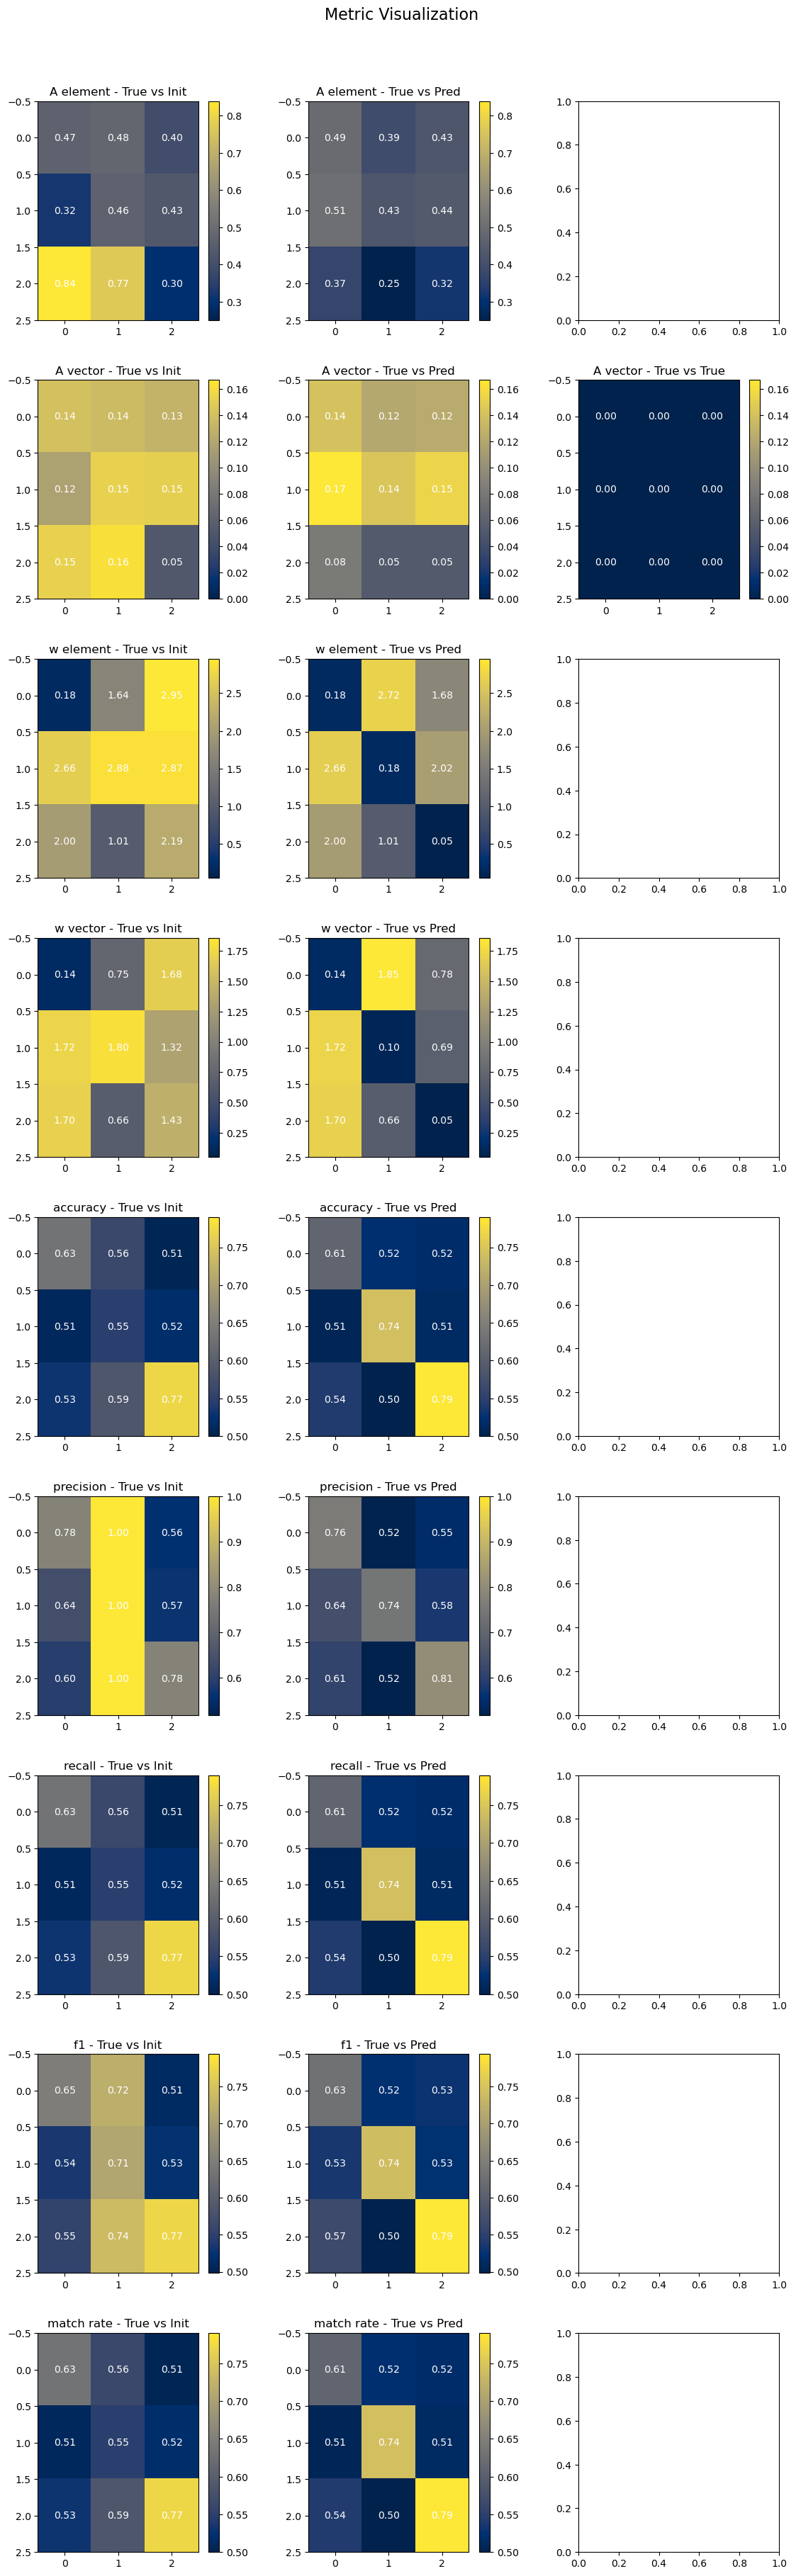

In [102]:
colormap = "cividis"
storage_all #(true, pred, true to init/pred, metric)
metrics = ["A element", "A vector", "w element", "w vector", "accuracy", "precision", "recall", "f1", "match rate"]

fig, axes = plt.subplots(len(metrics), 3, figsize=(12, 36))
fig.tight_layout(pad=4.0)

# Iterate through metrics and subplots
for idx, metric in enumerate(metrics):
    # Extract data for the current metric
    true2init = storage_all[:, :, 0, idx]
    true2pred = storage_all[:, :, 1, idx]
    

    # Compute vmin and vmax for the current row (shared between true2init and true2pred)
    vmin = min(true2init.min(), true2pred.min())
    vmax = max(true2init.max(), true2pred.max())

    if idx == 1:
        true2true = storage_all[:, :, 2, idx]
        vmin = min(vmin, true2true.min())
        vmax = max(vmax, true2true.max())

    # Plot true-to-init
    ax_init = axes[idx, 0]
    c1 = ax_init.imshow(true2init, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
    ax_init.set_title(f"{metric} - True vs Init")
    fig.colorbar(c1, ax=ax_init)
    # Add text annotations for each value
    for i in range(true2init.shape[0]):
        for j in range(true2init.shape[1]):
            ax_init.text(j, i, f"{true2init[i, j]:.2f}", ha='center', va='center', color='white')

    # Plot true-to-pred
    ax_pred = axes[idx, 1]
    c2 = ax_pred.imshow(true2pred, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
    ax_pred.set_title(f"{metric} - True vs Pred")
    fig.colorbar(c2, ax=ax_pred)
    # Add text annotations for each value
    for i in range(true2pred.shape[0]):
        for j in range(true2pred.shape[1]):
            ax_pred.text(j, i, f"{true2pred[i, j]:.2f}", ha='center', va='center', color='white')

    # Plot true-to-true
    if idx == 1:
        ax_pred = axes[idx, 2]
        c2 = ax_pred.imshow(true2true, aspect='auto', cmap=colormap, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f"{metric} - True vs True")
        fig.colorbar(c2, ax=ax_pred)
        # Add text annotations for each value
        for i in range(true2true.shape[0]):
            for j in range(true2true.shape[1]):
                ax_pred.text(j, i, f"{true2true[i, j]:.2f}", ha='center', va='center', color='white')

# Add overall figure title
fig.suptitle("Metric Visualization", fontsize=16, y=1.02)

# Display the plots
plt.show()


In [ ]:
N=500
dim_output=2
D = 7
K = 2


def metric_test(N, K, D, dim_output, num_models = 3, testN = 3000):
    '''
    ws = np.zeros((num_init, num_states, n_features + 1, obs_dim))
    As = np.zeros((num_init, num_states, num_states))
    pi0s = np.zeros((num_init, num_states))
    
    '''

    # true model params
    A_true_all = np.zeros((num_models, K, K))
    w_true_all = np.zeros((num_models, K, D+1, dim_output))
    pi0_true_all = np.zeros((num_models, K))
    true_states_seq_all = np.zeros((num_models, N))


    # init pred model params
    A_init_all = np.zeros_like(A_true_all)
    w_init_all = np.zeros_like(w_true_all)
    pi0_init_all = np.zeros_like(pi0_true_all)
    init_states_seq_all = np.zeros_like(true_states_seq_all)
    # pred(post training) model params
    A_pred_all = np.zeros_like(A_true_all)
    w_pred_all = np.zeros_like(w_true_all)
    pi0_pred_all = np.zeros_like(pi0_true_all)
    pred_states_seq_all = np.zeros_like(true_states_seq_all)
    

    for i in range(num_models):
        # Set up true model and generate data
        X, Y, _, A_true, w_true, pi0_true, m_true = gen_true_param(N, K, D, dim_output)

        X_test, Y_test, true_states_seq = m_true.generate_data(testN)
        A_true_all[i] = A_true
        w_true_all[i] = w_true
        pi0_true_all[i] = pi0_true
        true_states_seq_all[i] = true_states_seq.astype(int)

        # Fit a new model
        m = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
        A_init=m.transition_matrix
        w_init=m.w
        pi0_init  = m.pi0
        init_states_seq = m.mostprob_states(X_test, Y_test).astype(int)
        

        A_init_all[i] = A_init
        w_init_all[i] = w_init
        pi0_init_all[i] = pi0_init
        init_states_seq_all[i] = init_states_seq

        lls_pred,A_pred,w_pred,pi0_pred = m.fit(Y,X,A_init,w_init, pi0=pi0_init, fit_init_states=True)
        pred_states_seq = m.mostprob_states(X_test, Y_test)
        A_pred_all[i] = A_pred
        w_pred_all[i] = w_pred
        pi0_pred_all[i] = pi0_pred
        pred_states_seq_all[i] = pred_states_seq.astype(int)

    result = {
        'A_true_all': A_true_all,
        'w_true_all': w_true_all,
        'pi0_true_all': pi0_true_all,
        'true_states_seq_all': true_states_seq_all,
        'A_init_all': A_init_all,
        'w_init_all': w_init_all,
        'pi0_init_all': pi0_init_all,
        'init_states_seq_all': init_states_seq_all,
        'A_pred_all': A_pred_all,
        'w_pred_all': w_pred_all,
        'pi0_pred_all': pi0_pred_all,
        'pred_states_seq_all': pred_states_seq_all

    }
    # Analysis
    storage_all = np.zeros((num_models, num_models, 2, 9)) #2: init-0, pred-1 # (true, pred, true to init/pred, metric)
    
    for true_i in range(num_models):
        for pred_i in range(num_models):
            # extract the true params
            true_states_seq = true_states_seq_all[true_i]
            A_true = A_true_all[true_i]
            w_true = w_true_all[true_i]
            # extract the pred init params
            init_states_seq = init_states_seq_all[pred_i]
            A_init = A_init_all[pred_i]
            w_init = w_init_all[pred_i]
            # extract the pred params
            pred_states_seq = pred_states_seq_all[pred_i]
            A_pred = A_pred_all[pred_i]
            w_pred = w_pred_all[pred_i]

            # Permute the pred init states to align with true states
            init_states_seq = init_states_seq.astype(int)
            true_states_seq = true_states_seq.astype(int)
            pred_states_seq = pred_states_seq.astype(int)
            
            perm_init = find_permutation(init_states_seq, true_states_seq)
            init_states_perm = np.array([perm_init[init_states_seq[idx]] for idx in range(N)])
            A_perm_init = A_init[np.ix_(perm_init, perm_init)]
            w_perm_init = w_init[perm_init, :, :]
            # Permute the pred states to align with true states
            perm = find_permutation(pred_states_seq, true_states_seq)
            pred_states_perm = np.array([perm[pred_states_seq[idx]] for idx in range(N)])
            A_perm = A_pred[np.ix_(perm, perm)]
            w_perm = w_pred[perm, :, :]

            # Metric
            # Matrix comparison
            A_true2pred_element = matrix_comp(A_true, A_perm, metric="element") #0
            A_true2pred_vector = matrix_comp(A_true, A_perm, metric="vector") #1
            A_true2init_element = matrix_comp(A_true, A_init, metric="element")
            A_true2init_vector = matrix_comp(A_true, A_init, metric="vector")

            w_true2pred_element = matrix_comp(w_true, w_perm, metric="element") #2
            w_true2pred_vector = matrix_comp(w_true, w_perm, metric="vector") #3
            w_true2init_element = matrix_comp(w_true, w_init, metric="element")
            w_true2init_vector = matrix_comp(w_true, w_init, metric="vector")
            # State seq evaluation
            res_map_true2pred = evaluate_classification(pred_states_perm, true_states_seq)
            accuracy_true2pred = res_map_true2pred['accuracy'] #4
            precision_true2pred = res_map_true2pred['precision'] #5
            recall_true2pred = res_map_true2pred['recall'] #6
            f1_true2pred = res_map_true2pred['f1_score'] #7

            res_map_true2init = evaluate_classification(init_states_perm, true_states_seq)
            accuracy_true2init = res_map_true2init['accuracy']
            precision_true2init = res_map_true2init['precision']
            recall_true2init = res_map_true2init['recall']
            f1_true2init = res_map_true2init['f1_score']

            # matching rate of state seq
            mat_rate_true2pred = calculate_match_rate(pred_states_perm, true_states_seq) #8
            mat_rate_true2init = calculate_match_rate(init_states_perm, true_states_seq)

            # Storage
            storage_all[true_i, pred_i, 0] = np.array([A_true2init_element, A_true2init_vector, w_true2init_element, w_true2init_vector, \
                accuracy_true2init, precision_true2init, recall_true2init, f1_true2init, mat_rate_true2init])

            storage_all[true_i, pred_i, 1] = np.array([A_true2pred_element, A_true2pred_vector, w_true2pred_element, w_true2pred_vector, \
                accuracy_true2pred, precision_true2pred, recall_true2pred, f1_true2pred, mat_rate_true2pred])

    result['storage_all'] = storage_all
    return result
    

In [ ]:
result = metric_test(N, K, D, dim_output, num_models = 3)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter10
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9
Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wliu25/miniconda3/envs/glmhmm/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


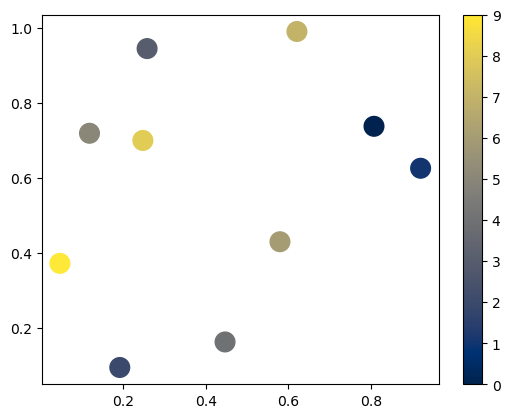

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data
x = np.random.rand(10)
y = np.random.rand(10)
colors = np.arange(10)  # Categorical values

# Use a clearer categorical colormap
plt.scatter(x, y, c=colors, cmap="cividis", s=200)
plt.colorbar()
plt.show()


In [3]:
X1, Y1, true_states_seq1, A_true1, w_true1, pi0_true1 = gen_true_param(N, K, D, dim_output)
X2, Y2, true_states_seq2, A_true2, w_true2, pi0_true2 = gen_true_param(N, K, D, dim_output)

In [4]:
m1 = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
A_init1=m1.transition_matrix
w_init1=m1.w
lls_pred1,A_pred1,w_pred1,pi0_pred1 = m1.fit(Y1,X1,A_init1,w_init1, fit_init_states=True)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


In [12]:
pred_states_seq1 = m1.mostprob_states(X1, Y1)

/data/users/weixuan/work/model/glmhmm/glmhmm.py:462: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))
/data/users/weixuan/work/model/glmhmm/glmhmm.py:464: RuntimeWarning: divide by zero encountered in log
  np.log(self._compute_likelihood(X_augmented[t], Y[t])[j]))


In [13]:
pred_states_seq1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [5]:
m2 = GLMHMM(N, K, D, dim_output, 1.0) #N, n_states, n_features, n_outputs
A_init2=m2.transition_matrix
w_init2=m2.w
lls_pred2,A_pred2,w_pred2,pi0_pred2 = m2.fit(Y2,X2,A_init2,w_init2, fit_init_states=True)

Iter1
Iter2
Iter3
Iter4
Iter5
Iter6
Iter7
Iter8
Iter9


In [10]:
pred_states_seq2 = m2.mostprob_states(X2, Y2)

In [11]:
pred_states_seq2, 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,

In [41]:
# Apply those metrics

# Permute states 
perm1 = find_permutation(pred_states_seq1, true_states_seq1)
pred_states_perm1 = np.array([perm1[pred_states_seq1[idx]] for idx in range(N)])
A_perm1 = A_pred1[np.ix_(perm1, perm1)]
w_perm1 = w_pred1[perm1, :, :]

In [38]:
w_true1

array([[[-0.19013904, -0.93677205],
        [-0.74692553, -0.593289  ],
        [-0.38786624, -0.16372864],
        [-0.53119145, -0.16631012],
        [-0.00254784, -0.98334534],
        [-0.65384389, -0.92761853],
        [-0.11354219, -0.67730854],
        [ 0.        ,  0.        ]],

       [[ 0.52831886,  0.92349298],
        [ 0.20323374,  0.7210474 ],
        [ 0.38743098,  0.84596426],
        [ 0.31790035,  0.22014139],
        [ 0.90133491,  0.65710237],
        [ 0.7213772 ,  0.04972955],
        [ 0.88076277,  0.67962071],
        [ 0.        ,  0.        ]]])

In [42]:
A_comp_element1 = matrix_comp(A_true1, A_perm1, metric="element")
A_comp_vector1 = matrix_comp(A_true1, A_perm1, metric="vector")
w_comp_element1 = matrix_comp(w_true1, w_perm1, metric="element")
w_comp_vector1 = matrix_comp(w_true1, w_perm1, metric="vector")


In [44]:
A_comp_element, A_comp_vector, w_comp_element1, w_comp_vector1

(0.6163059150382226, 0.4979360340877688, inf, 1.2950123981403079)

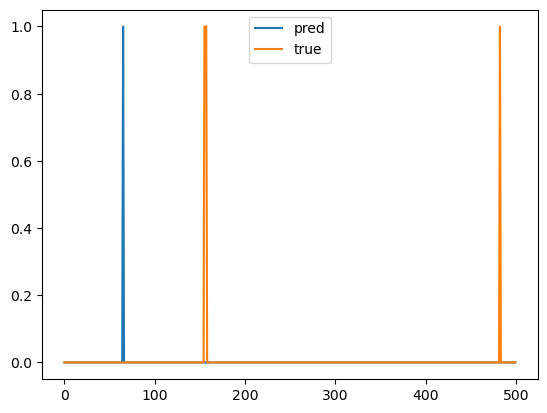

In [29]:
plt.plot(pred_states_perm1, label='pred')
plt.plot(true_states_seq1, label = 'true')
plt.legend()

In [27]:
perm2 = find_permutation(pred_states_seq2, true_states_seq2)
pred_states_perm2 = np.array([perm2[pred_states_seq2[idx]] for idx in range(N)])

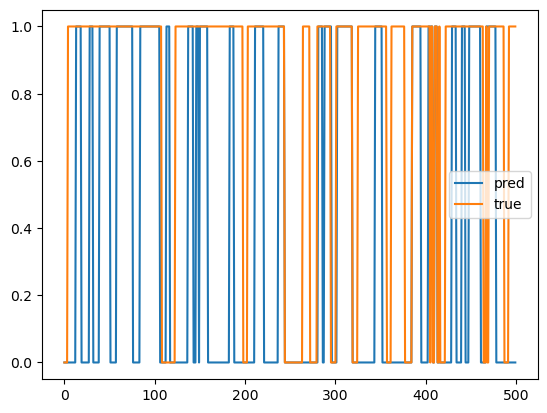

In [28]:
plt.plot(pred_states_perm2, label='pred')
plt.plot(true_states_seq2, label = 'true')
plt.legend()

In [ ]:
W_permuted = W[perm, :, :]